In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd   
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
#scalars used 
cg = 1.78
eps = 1e-3
laplace_scale = 1.0 / (2**.5)

In [110]:
#setting seed
np.random.seed(50)

In [111]:
2*((2*cg)**.5)**2

7.12

## Helper Functions

In [121]:
def random_generator(n,a,gamma=(2*cg)**.5):
    """Draws n random numbers from normal, laplace and 
    cauchy distributions with parameter a"""
    distributions = {}
    distributions['normal'] = a + np.random.randn(n)
    distributions['laplace'] = a + np.random.laplace(size = n,scale = laplace_scale)
    distributions['cauchy'] = a + scipy.stats.cauchy.rvs(size=n,loc = 0, scale = gamma)
    return distributions

def cauchy_likelihood(data, gamma, a):
    """Likelihood function of cauchy distribution"""
    return -np.sum(np.log(1 + ((data-a)/gamma)**2))

def f(data,gamma,a):
    """Optimization function for the cauchy distribution (given gamma)."""
    return np.sum((a-data)/(1 + ((data-a)/gamma)**2))

def df_da(data,gamma,a):
    """derivative of f with respect to a."""
    return np.sum((1 - ((data-a)/gamma)**2)/((1 + ((data-a)/gamma)**2)**2))

def nr(data,guess,gamma,iterations=1000):
    """Newton-Raphson method for estimating the location parameter of a Cauchy distribution."""
    for iteration in range(iterations):
        y = f(data,gamma, guess)
        dy_dA = df_da(data, gamma, guess) + eps*1e-3
        guess -= y/dy_dA
        if abs(y/dy_dA) < eps:
            break
    return guess

def grad_desc(data,guess,gamma,iterations=1000):
    """gradient descent method for estimating the location parameter of a cauchy distribution."""
    lr = 1e-3
    pguess = 1e5
    for _ in range(iterations):
        y = f(data,gamma, guess)
        pguess = guess
        guess -= lr*y
        if abs(pguess-guess) < eps:
            break
    return guess

def mle_estimates(distributions, gamma, guess):
    """Calculates the mle estimates for normal, laplace and cauchy distributions."""
    estimates = {}
    for key in distributions.keys():
        if key == 'normal':
            estimates[key] = np.mean(distributions[key])
        elif key == 'laplace':
            estimates[key] = np.median(distributions[key])
        elif key == 'cauchy':
            estimates[key] = nr(distributions[key], guess, gamma=gamma,iterations=10000)
    return estimates

def Fisher_information(n):
    """Calculates the fisher information for the cauchy distribution."""
    return {"normal" : 1/n, "laplace": 2/n,  "cauchy": 4*cg } # "cauchy": 1/(2*gamma**2)

## Experiments

In [120]:
# from tqdm import tqdm

def realisations(n, a, num_realisations):
    """Generates n random numbers and calculates MLE estimates for num_realisations."""
    estimates = {"normal": [], "laplace": [], "cauchy": []}
    
    for _ in tqdm(
        range(num_realisations),
        desc=f"n={n} | Realisations",
        leave=False,
        dynamic_ncols=True,
    ):
        distributions = random_generator(n, a)
        estimate = mle_estimates(distributions, gamma=(2 * cg) ** 0.5, guess=np.median(distributions["cauchy"]))


        for key in estimate:
            estimates[key].append(estimate[key])
    
    return estimates

def get_statistics(estimates):
    """Calculates mean and standard deviation of MLE estimates."""
    statistics = {}
    for key in estimates:
        statistics[key] = {
            'mean': np.mean(estimates[key]),
            'var': np.var(estimates[key])
        }
    return statistics

def iter_over_sample_size(ns, a, num_realisations):
    """Iterates over different sample sizes and calculates MLE estimates."""
    estimates = {}
    stats = {}

    outer = tqdm(ns, desc="Sample Sizes", dynamic_ncols=True)
    for n in outer:
        outer.set_description(f"Sample size: n={n}")
        estimates[n] = realisations(n, a, num_realisations)
        stats[n] = get_statistics(estimates[n])
        outer.write(f"Done: n={n}, num_real={num_realisations}")
    
    return estimates, stats

# def give_mean_results(a, sample_sizes, num_realisations):
#     data = {}
#     for ni in sample_sizes:
#         data[f"{ni}"]={}
#         for nri in num_realisations:
#             data[f"{ni}"][f"normal_{nri}"]={}
#             data[f"{ni}"][f"laplace_{nri}"]={}
#             data[f"{ni}"][f"cauchy_{nri}"]={}
            
#     for num_real in num_realisations:
#         estimates, stats = iter_over_sample_size(sample_sizes, a, num_real)
#         for ni in sample_sizes:
#             # data[f"{ni}"][f"normal_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f}  ± {np.sqrt(stats[ni]["normal"]["var"]):.3f}'
#             # data[f"{ni}"][f"laplace_{nr}"] = rf'{stats[ni]["laplace"]["mean"]:.3f} ± {np.sqrt(stats[ni]["laplace"]["var"]):.3f}'
#             # data[f"{ni}"][f"cauchy_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f} ± {np.sqrt(stats[ni]["cauchy"]["var"]):.3f}'

#             data[f"{ni}"][f"cauchy_{nr}"] = rf'{stats[ni]["normal"]["mean"]:.3f}'
#     df = pd.DataFrame(data).T
#     #ordered_cols = [f"Cauchy_{'no of realisations:',{nr} }" for nr in num_realisations]
    
#     # ordered_cols.extend([f"laplace_{nr}" for nr in num_realisations])
#     # ordered_cols.extend([f"cauchy_{nr}" for nr in num_realisations])
#     ordered_cols = [f"cauchy_{nr}" for nr in num_realisations]
#     df = df.loc[:,ordered_cols]
#     return df, estimates, stats

# def give_variance_results(a, sample_sizes, num_realisations):
#     data = {}
#     for ni in sample_sizes:
#         data[f"{ni}"]={}
#         for nri in num_realisations:
#             data[f"{ni}"][f"normal_{nri}"]={}
#             data[f"{ni}"][f"laplace_{nri}"]={}
#             data[f"{ni}"][f"cauchy_{nri}"]={}
            
#     for nr in num_realisations:
#         estimates, stats = iter_over_sample_size(sample_sizes, a, nr)
#         for ni in sample_sizes:
#             data[f"{ni}"][f"cauchy_{nr}"] = rf'{np.sqrt(stats[ni]["cauchy"]["var"]):.3f}'
#     df = pd.DataFrame(data).T
#     # ordered_cols = [f"normal_{nr}" for nr in num_realisations]
#     # ordered_cols.extend([f"laplace_{nr}" for nr in num_realisations])
#     #ordered_cols = ([f"Cauchy_{'no of realisations:',{nr}}" for nr in num_realisations])
#     ordered_cols = [f"cauchy_{nr}" for nr in num_realisations]
#     df = df.loc[:,ordered_cols]
#     return df, estimates, stats


## Plotting functions

In [114]:
def plot_cdf(a, data, stat ,label='CDF', color='blue', axis=None):
    """Plots the CDF of the data."""
    if axis is None:
        _, axis = plt.subplots(figsize=(5, 5), layout="constrained")
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    axis.step(sorted_data, cdf, where='post', label=label, color=color)
    axis.set_xlabel(r'Value of $\hat{a}$')
    axis.set_ylabel('Cumulative Probability')
    axis.set_title(f"CDF of {label} with mean: {stat['mean']:.3E} var: {stat['var']:.3E}")
    axis.set_xlim(max(-3+a,np.min(data)), min(3+a,np.max(data)))

def plot_cdf_pdf(ns,a,estimates,stats):
    for n in ns:
        _, axs = plt.subplots(3, 2, figsize=(10, 5), layout="constrained")
        for i,key in enumerate(estimates[n].keys()):
            axs[i,0].hist(estimates[n][key], density=True, bins=100, alpha=0.5, color='blue', label='PDF',range=(max(-3+a,np.min(estimates[n][key])), min(3+a,np.max(estimates[n][key]))))
            axs[i,0].set_title(f"PDF of {key} with sample size {n}")
            plot_cdf(a, estimates[n][key], stats[n][key], label=key, color='blue', axis=axs[i,1])
            axs[i,1].set_title(f"CDF of {key} with sample size {n}")
        plt.show()

def plot_mean_var(stats):
    _, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
    mean, var = {"cauchy": []},{ "cauchy": []}
    for n in stats.keys():
        for key in mean.keys():
            mean[key].append(stats[n][key]['mean'])
            var[key].append(stats[n][key]['var'])
    for key in mean.keys():
        axs[0].semilogy(stats.keys(), mean[key], label=key)
        axs[1].semilogy(stats.keys(), var[key], label=key)
    axs[0].set_xlabel(r'Sample Size')
    axs[0].set_ylabel(r'Mean of $\hat{a}$')
    axs[0].set_title(r'Mean of $\hat{a}$')
    # axs[0].set_xscale(r'log')
    axs[1].set_xlabel(r'Sample Size')
    axs[1].set_ylabel(r'Variance of $\hat{a}$')
    axs[1].set_title(r'Variance of $\hat{a}$')
    # axs[1].set_xscale(r'log')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [115]:
n = [1, 10, 100, 1000, 10000]#, 1000, 10000]
num_realisations = [10,100,1000]

In [116]:
a = 1.0
df1,estimates1,stats1 = give_mean_results(a, n, num_realisations)
df1.head()

Sample size: n=10:   0%|          | 0/5 [00:00<?, ?it/s]

Done: n=1, num_real=10


Sample size: n=100:  40%|████      | 2/5 [00:00<00:00,  5.17it/s]

Done: n=10, num_real=10


Sample size: n=1000:  40%|████      | 2/5 [00:00<00:00,  5.17it/s]

Done: n=100, num_real=10


Sample size: n=10000:  40%|████      | 2/5 [00:00<00:00,  5.17it/s]

Done: n=1000, num_real=10


Sample size: n=10000: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


Done: n=10000, num_real=10


Sample size: n=10:  20%|██        | 1/5 [00:00<00:00,  7.45it/s]

Done: n=1, num_real=100


Sample size: n=100:  20%|██        | 1/5 [00:00<00:00,  7.45it/s]

Done: n=10, num_real=100


Sample size: n=1000:  60%|██████    | 3/5 [00:00<00:00, 13.73it/s]

Done: n=100, num_real=100


Sample size: n=10000:  60%|██████    | 3/5 [00:00<00:00, 13.73it/s]

Done: n=1000, num_real=100


Sample size: n=10000: 100%|██████████| 5/5 [00:00<00:00, 10.20it/s]


Done: n=10000, num_real=100


Sample size: n=10:  20%|██        | 1/5 [00:00<00:01,  3.33it/s]

Done: n=1, num_real=1000


Sample size: n=100:  40%|████      | 2/5 [00:08<00:14,  4.79s/it]

Done: n=10, num_real=1000


Sample size: n=1000:  60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

Done: n=100, num_real=1000


Sample size: n=10000:  80%|████████  | 4/5 [00:08<00:01,  1.78s/it]

Done: n=1000, num_real=1000


Sample size: n=10000: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

Done: n=10000, num_real=1000


,cauchy_10,cauchy_100,cauchy_1000
1,1.406,1.076,0.989
10,0.920,1.028,1.026
100,1.047,0.977,1.002
1000,1.008,1.000,0.999
10000,1.003,1.000,1.000


In [117]:
def generate_combined_table(a_values, sample_sizes, realisations_list):
    import numpy as np
    import pandas as pd

    all_tables = {}

    for nr in realisations_list:
        table = {}
        for n in sample_sizes:
            row = {}
            for a in a_values:
                estimates, stats = iter_over_sample_size([n], a, nr)
                mean = stats[n]["cauchy"]["mean"]
                std = stats[n]["cauchy"]["var"]
                row[f"Mean (A={a})"] = f"{mean:.3f}"
                row[f"Variance (A={a})"] = f"{std:.3f}"
            table[n] = row

        df = pd.DataFrame(table).T
        df.index.name = f"Sample Size"
        all_tables[nr] = df

    return all_tables
a_values = [1, 10]
sample_sizes = [1, 10, 100, 1000, 10000]
realisations_list = [1000]

tables = generate_combined_table(a_values, sample_sizes, realisations_list)

# Print or export any table
for nr in realisations_list:
    print(f"\nTable for Realisations = {nr}")
    print(tables[nr])



Sample size: n=1: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Done: n=1, num_real=1000


Sample size: n=1: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Done: n=1, num_real=1000


Sample size: n=10: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Done: n=10, num_real=1000


Sample size: n=10: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Done: n=10, num_real=1000


Sample size: n=100: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Done: n=100, num_real=1000


Sample size: n=100: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Done: n=100, num_real=1000


Sample size: n=1000: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Done: n=1000, num_real=1000


Sample size: n=1000: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Done: n=1000, num_real=1000


Sample size: n=10000: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Done: n=10000, num_real=1000


Sample size: n=10000: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

Done: n=10000, num_real=1000

Table for Realisations = 1000
            Mean (A=1)    Variance (A=1) Mean (A=10)    Variance (A=10)
Sample Size                                                            
1               -1.542         13297.793       9.265           3882.841
10           18371.288  516556230272.771   35725.029  3735600421305.376
100              1.005             0.082       9.985              0.069
1000             0.998             0.008      10.004              0.007
10000            1.000             0.001      10.000              0.001


In [56]:
a = 10.0
df10,estimates10,stats10 = give_variance_results(a, n, num_realisations)
df10.head()

Sample size: n=10:   0%|          | 0/5 [00:00<?, ?it/s]

Done: n=1, num_real=10


Sample size: n=100:   0%|          | 0/5 [00:00<?, ?it/s]

Done: n=10, num_real=10


Sample size: n=1000:   0%|          | 0/5 [00:00<?, ?it/s]

Done: n=100, num_real=10


Sample size: n=10000:   0%|          | 0/5 [00:00<?, ?it/s]

Done: n=1000, num_real=10


Sample size: n=10000: 100%|██████████| 5/5 [00:00<00:00, 39.72it/s]


Done: n=10000, num_real=10


Sample size: n=10:   0%|          | 0/5 [00:00<?, ?it/s]

Done: n=1, num_real=100


C:\Users\Asus\AppData\Local\Temp\ipykernel_20376\357615838.py:11: RuntimeWarning: overflow encountered in square
  denom = np.sum((gamma**2 - (x - data)**2) / (gamma**2 + (x - data)**2)**2)
C:\Users\Asus\AppData\Local\Temp\ipykernel_20376\357615838.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  update = num / denom
C:\Users\Asus\AppData\Local\Temp\ipykernel_20376\357615838.py:10: RuntimeWarning: invalid value encountered in divide
  num = np.sum((x - data) / (gamma**2 + (x - data)**2))
C:\Users\Asus\AppData\Local\Temp\ipykernel_20376\357615838.py:11: RuntimeWarning: invalid value encountered in divide
  denom = np.sum((gamma**2 - (x - data)**2) / (gamma**2 + (x - data)**2)**2)
Sample size: n=100:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

Done: n=10, num_real=100


Sample size: n=1000:  40%|████      | 2/5 [00:00<00:01,  2.95it/s]

Done: n=100, num_real=100


Sample size: n=10000:  80%|████████  | 4/5 [00:00<00:00,  5.70it/s]

Done: n=1000, num_real=100


Sample size: n=10000: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Done: n=10000, num_real=100


Sample size: n=10:  20%|██        | 1/5 [00:00<00:01,  3.78it/s]

Done: n=1, num_real=1000


Sample size: n=100:  40%|████      | 2/5 [00:02<00:05,  1.69s/it]

Done: n=10, num_real=1000


Sample size: n=1000:  60%|██████    | 3/5 [00:03<00:02,  1.08s/it]

Done: n=100, num_real=1000


Sample size: n=10000:  80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

Done: n=1000, num_real=1000


Sample size: n=10000: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

Done: n=10000, num_real=1000


,cauchy_10,cauchy_100,cauchy_1000
1,27.209,17.913,62.678
10,0.946,nan,nan
100,0.159,0.292,0.256
1000,0.051,0.088,0.085
10000,0.021,0.024,0.027


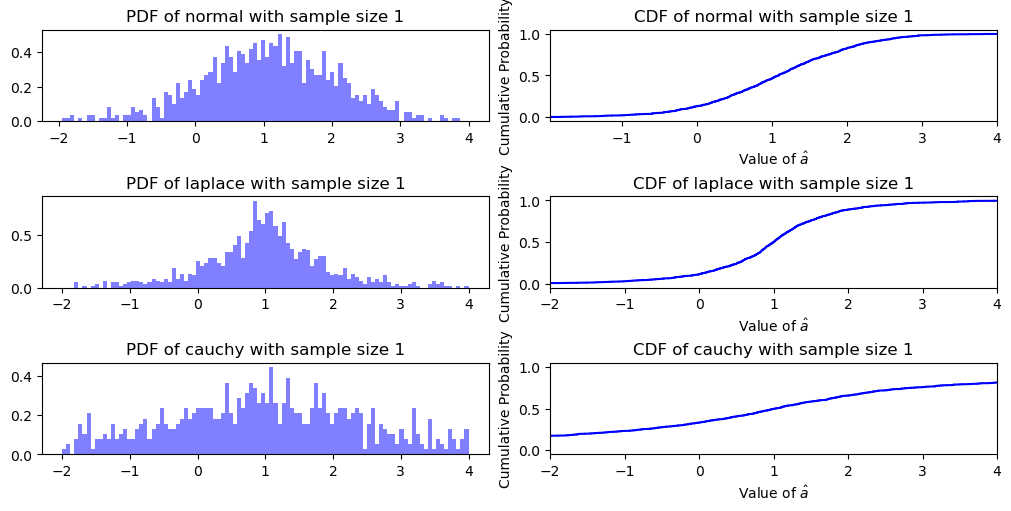

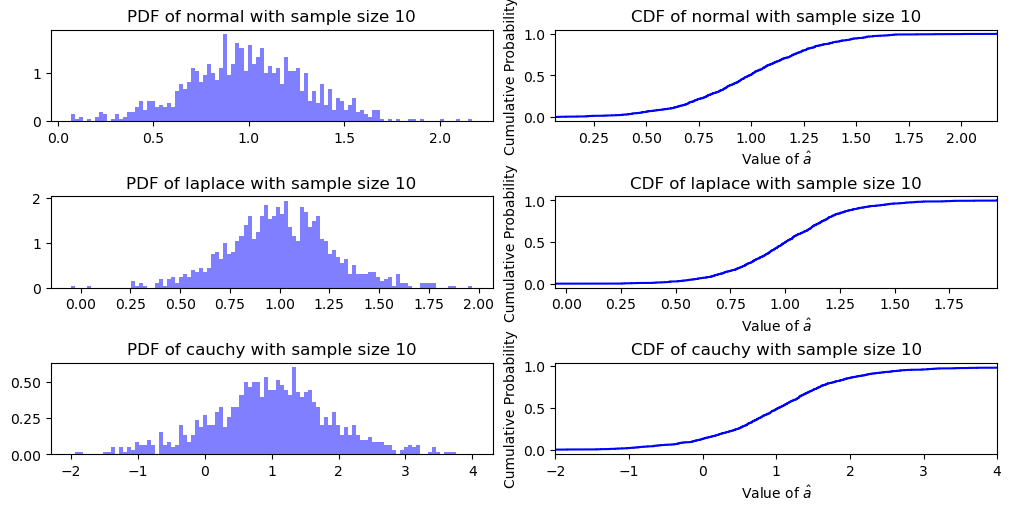

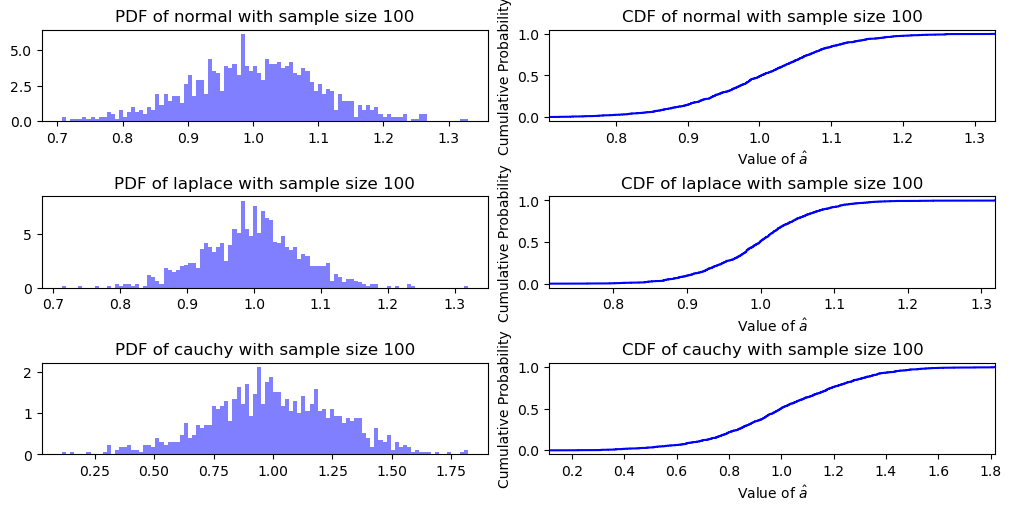

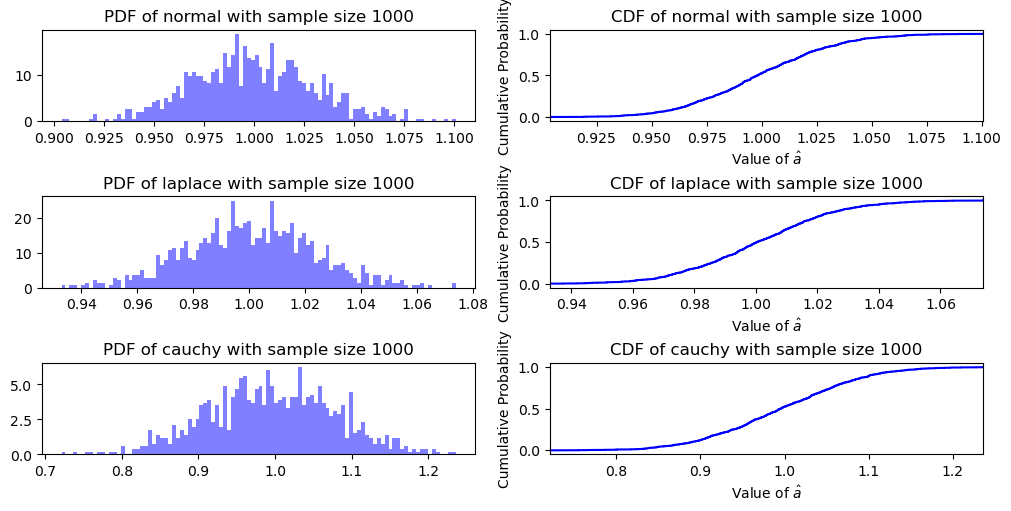

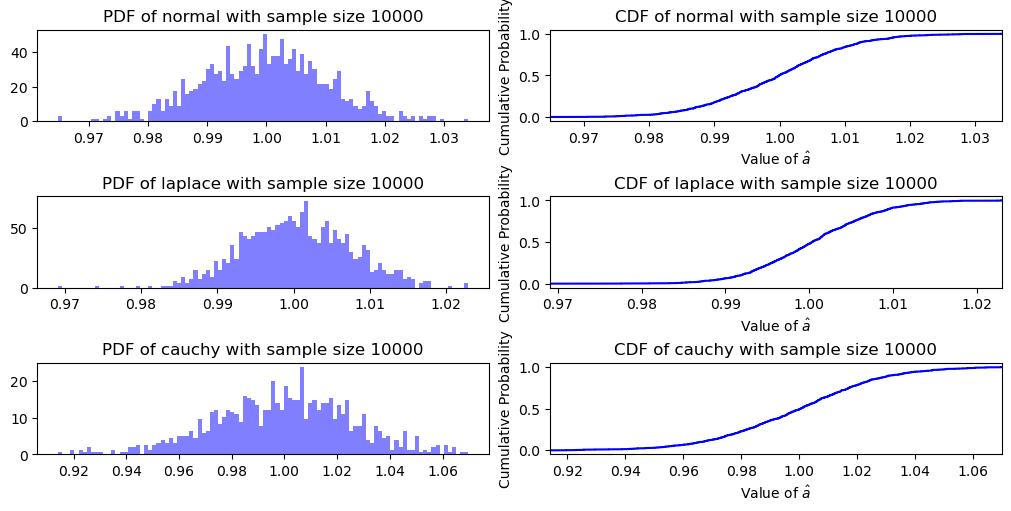

In [58]:
plot_cdf_pdf(n, 1, estimates1, stats1)

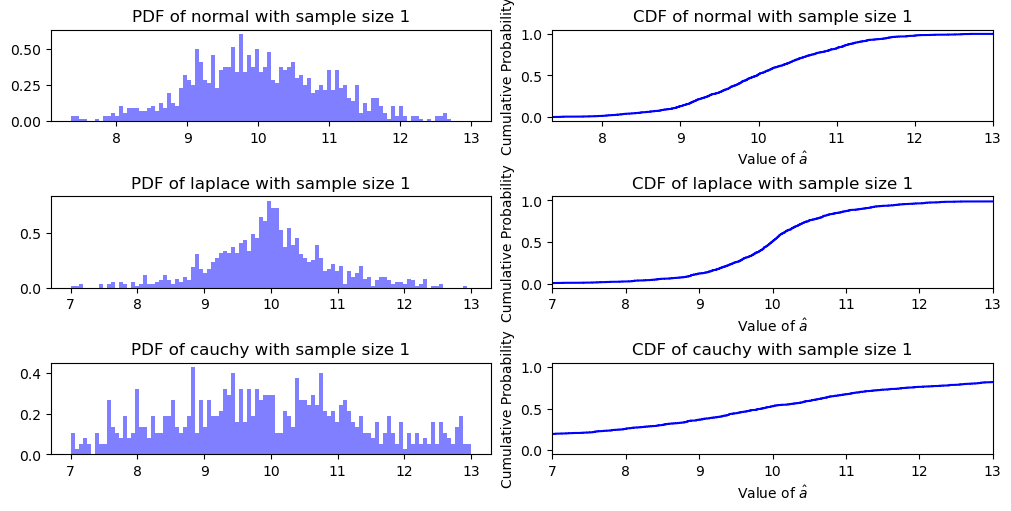

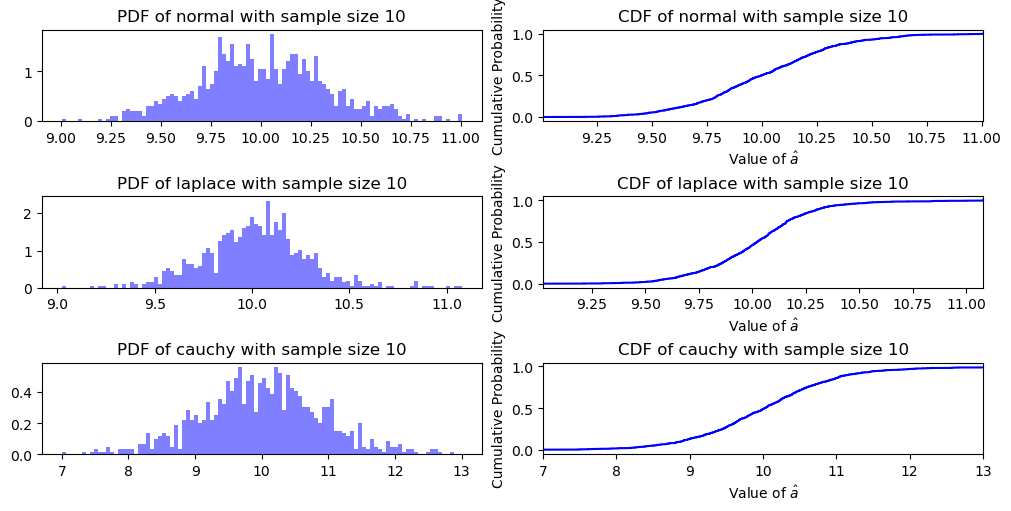

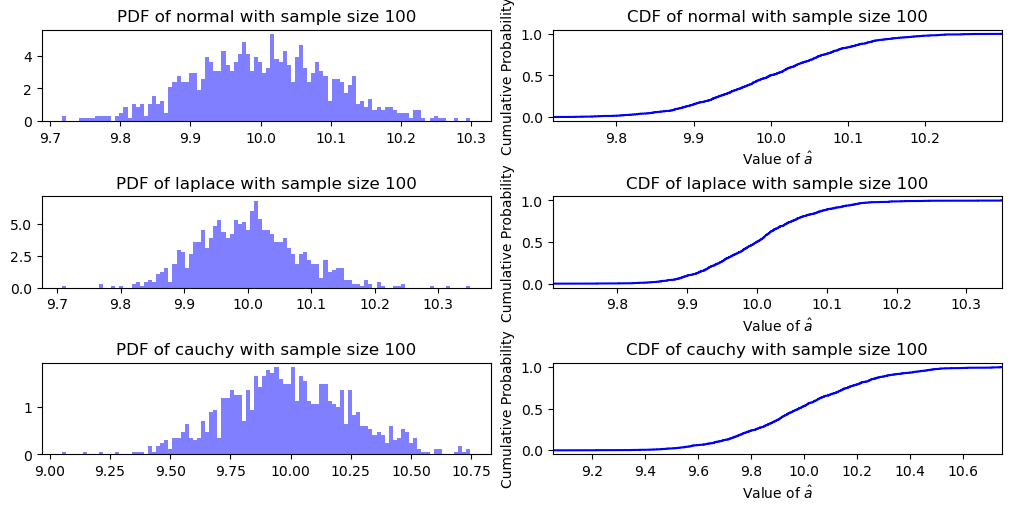

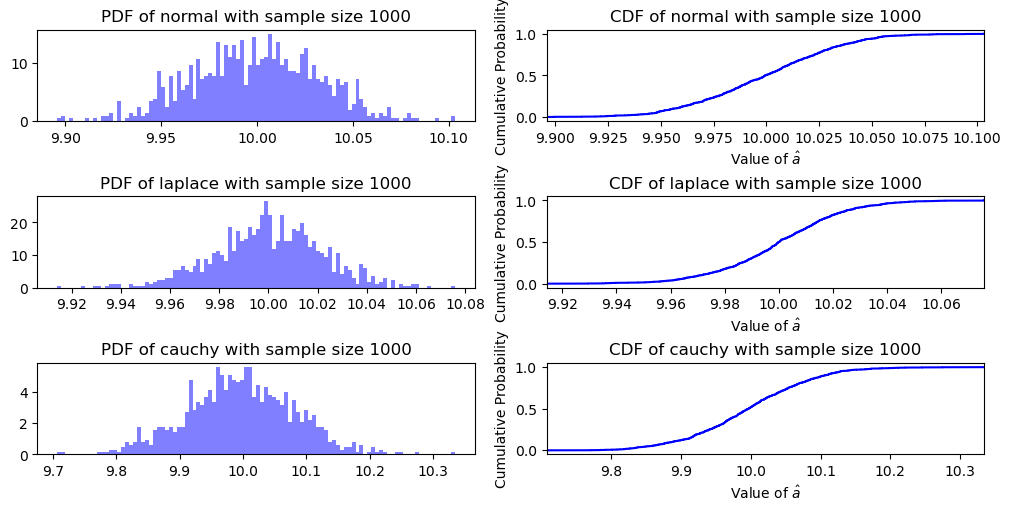

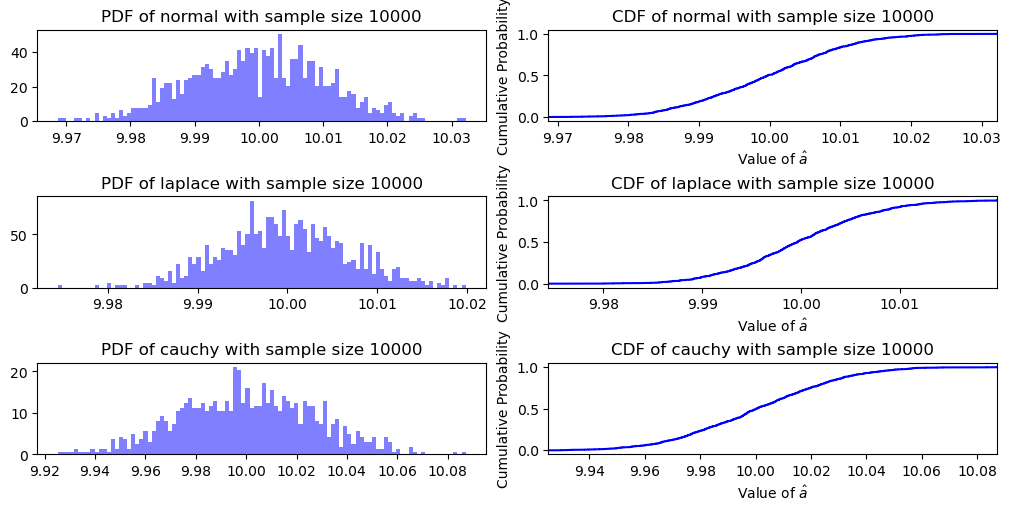

In [59]:
plot_cdf_pdf(n, 10, estimates10, stats10)

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# Set constants
cg = 1.78 # scale of Cauchy
A = 1   # true location
sample_sizes = [1,10,100,1000,10000]
num_realisations = 1000  # enough to get smooth PDF/CDF
gamma=np.sqrt(2*cg)

def generate_cauchy_samples(n, a, gamma= gamma):
    return (a + scipy.stats.cauchy.rvs(size=n,loc = 0, scale = gamma))

def mle_cauchy(data, gamma=np.sqrt(2*cg), guess=None, iterations=num_realisations, tol=1e-6):
    if guess is None:
        guess = np.median(data)
    a = guess
    for _ in range(iterations):
        num = np.sum((data - a) / (gamma**2 + (data - a)**2))
        den = np.sum((gamma**2 - (data - a)**2) / (gamma**2 + (data - a)**2)**2)
        step = num / den
        a -= step
        if abs(step) < tol:
            break
    return a

estimates_A1 = {}
estimates_A10 = {}
for A in [1, 10]:
    print(f"\n--- MLE Results for A = {A} ---")
    for n in tqdm(sample_sizes, desc=f"Sample sizes for A={A}"):
        est_list = []
        for _ in range(num_realisations):
            samples = generate_cauchy_samples(n, A)
            est = mle_cauchy(samples, gamma=gamma, guess=np.median(samples))
            est_list.append(est)
        est_array = np.array(est_list)
        print(f"N={n:5d} | Mean: {np.mean(est_array):.4f} | Variance: {np.var(est_array):.4f}")
        if A == 1:
            estimates_A1[n] = est_array
        else:
            estimates_A10[n] = est_array



--- MLE Results for A = 1 ---


Sample sizes for A=1:  20%|██        | 1/5 [00:00<00:00,  6.05it/s]

N=    1 | Mean: 1.8002 | Variance: 3640.6284


Sample sizes for A=1:  40%|████      | 2/5 [00:23<00:41, 13.92s/it]

N=   10 | Mean: 1.9356 | Variance: 1248.1235


Sample sizes for A=1:  60%|██████    | 3/5 [00:45<00:34, 17.47s/it]

N=  100 | Mean: -9.2976 | Variance: 70264.0768


Sample sizes for A=1:  80%|████████  | 4/5 [01:13<00:21, 21.84s/it]

N= 1000 | Mean: 6.5127 | Variance: 1750008.2788


Sample sizes for A=1: 100%|██████████| 5/5 [02:28<00:00, 29.61s/it]


N=10000 | Mean: -8.5156 | Variance: 70520.3113

--- MLE Results for A = 10 ---


Sample sizes for A=10:  20%|██        | 1/5 [00:00<00:00,  6.32it/s]

N=    1 | Mean: 9.8428 | Variance: 1043.1870


Sample sizes for A=10:  40%|████      | 2/5 [00:22<00:39, 13.00s/it]

N=   10 | Mean: 14.5781 | Variance: 12575.9928


Sample sizes for A=10:  60%|██████    | 3/5 [00:44<00:34, 17.39s/it]

N=  100 | Mean: 23.5379 | Variance: 32229.9477


Sample sizes for A=10:  80%|████████  | 4/5 [01:16<00:22, 22.91s/it]

N= 1000 | Mean: -2.9780 | Variance: 88193.2531


Sample sizes for A=10: 100%|██████████| 5/5 [02:24<00:00, 28.91s/it]

N=10000 | Mean: 21.4370 | Variance: 65881.1889


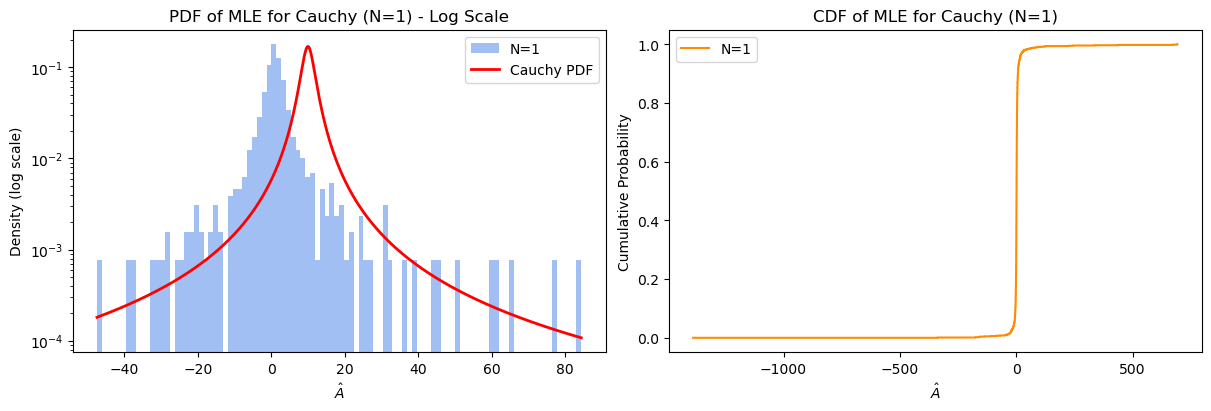

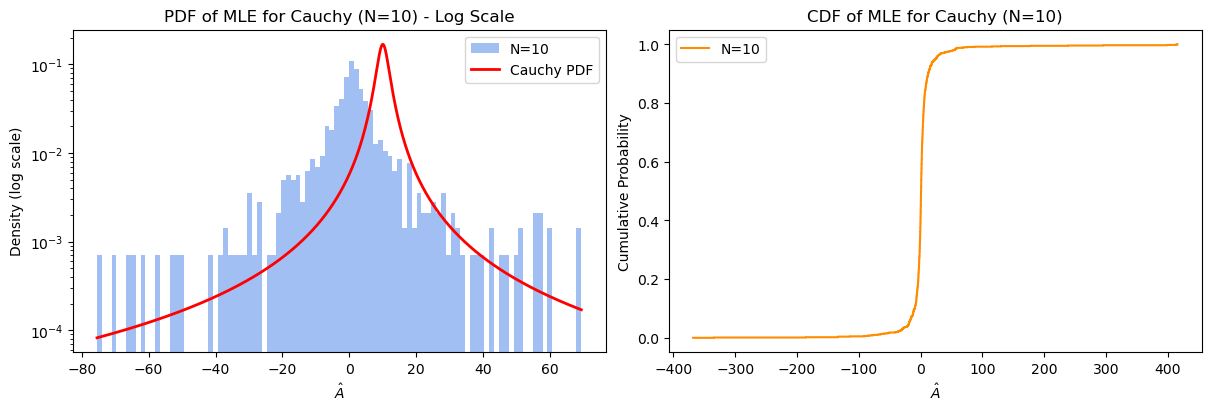

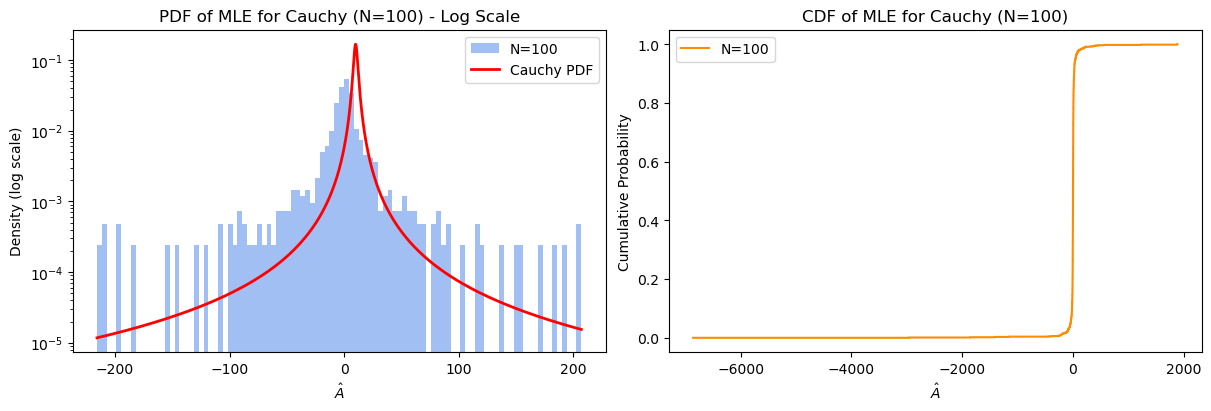

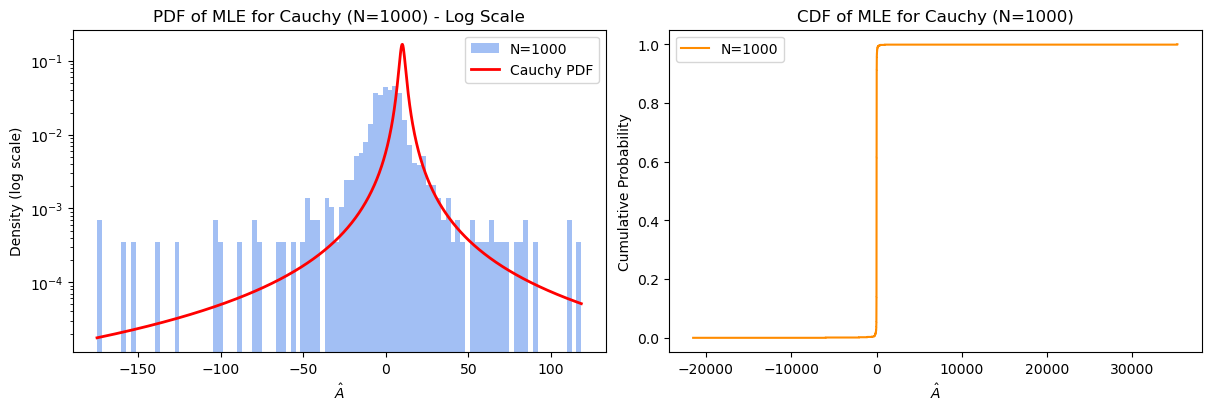

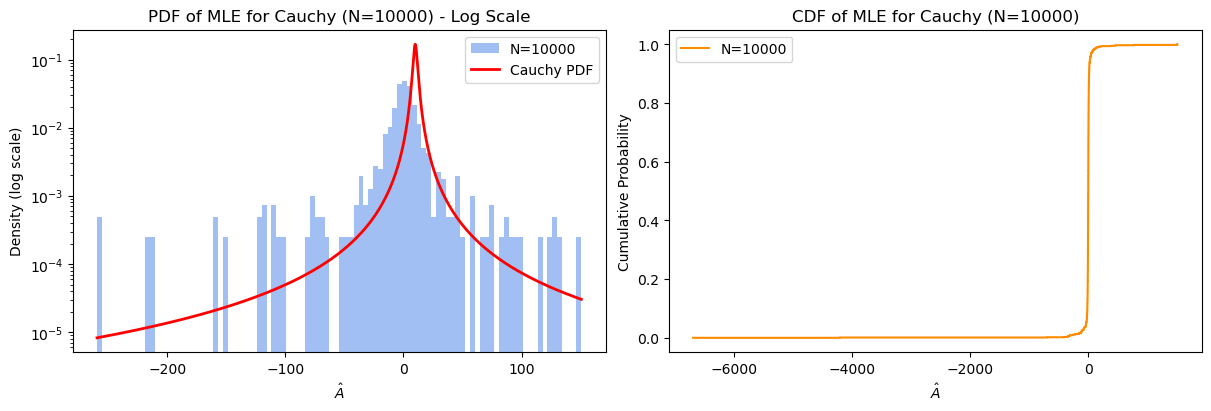

In [107]:
from scipy.stats import cauchy

def plot_pdf_cdf(estimates, A=1, scale=gamma):
    for n in sample_sizes:
        ests = estimates[n] # Only plot Cauchy estimates

        fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")

        # ---------- PDF with Log-Scale ----------
        # Histogram
        q_low, q_high = np.percentile(ests, [1, 99])  # Trim extreme outliers
        axs[0].hist(ests, bins=100, range=(q_low, q_high), density=True,
                    alpha=0.6, label=f'N={n}', color='cornflowerblue')

        # Theoretical PDF overlay
        x = np.linspace(q_low, q_high, 1000)
        pdf = cauchy.pdf(x, loc=A, scale=scale)
        axs[0].plot(x, pdf, color='red', lw=2, label='Cauchy PDF')

        axs[0].set_yscale('log')
        axs[0].set_title(f'PDF of MLE for Cauchy (N={n}) - Log Scale')
        axs[0].set_xlabel(r'$\hat{A}$')
        axs[0].set_ylabel('Density (log scale)')
        axs[0].legend()

        # ---------- CDF ----------
        sorted_est = np.sort(ests)
        cdf = np.linspace(0, 1, len(sorted_est))
        axs[1].step(sorted_est, cdf, label=f'N={n}', where='post', color='darkorange')

        axs[1].set_title(f'CDF of MLE for Cauchy (N={n})')
        axs[1].set_xlabel(r'$\hat{A}$')
        axs[1].set_ylabel('Cumulative Probability')
        axs[1].legend()

        plt.show()

plot_pdf_cdf(estimates_A1, A=A)


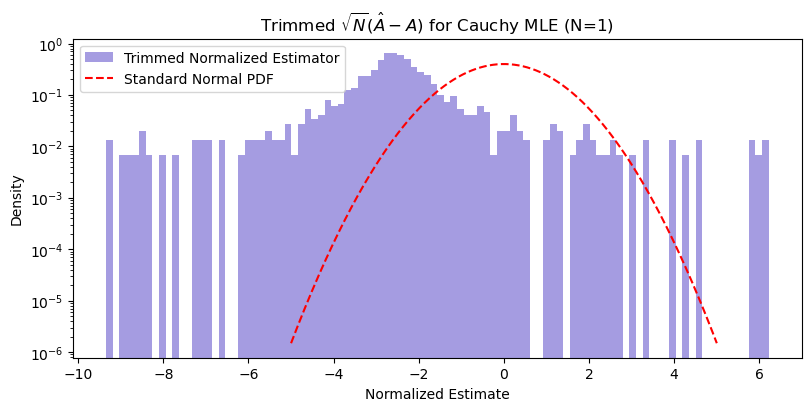

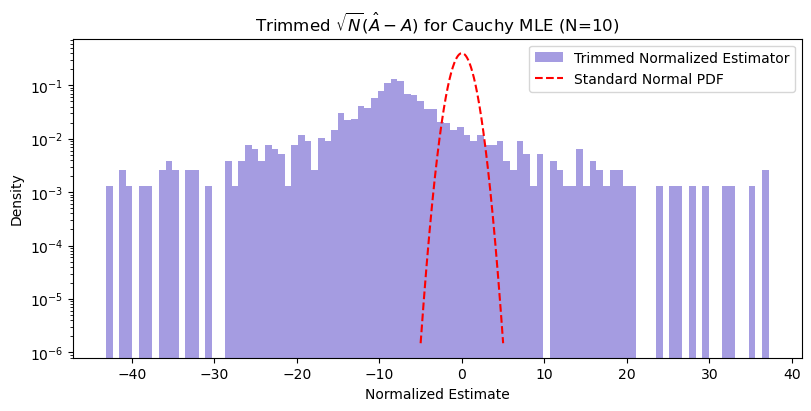

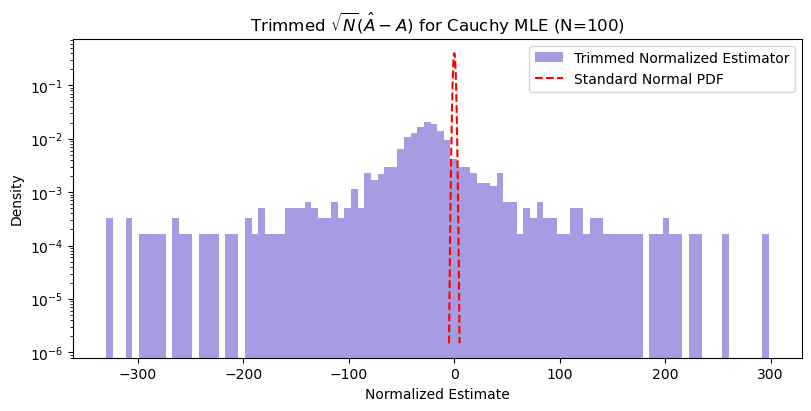

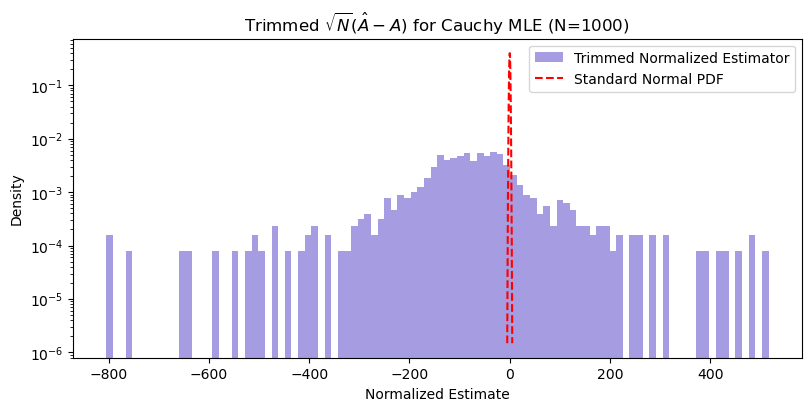

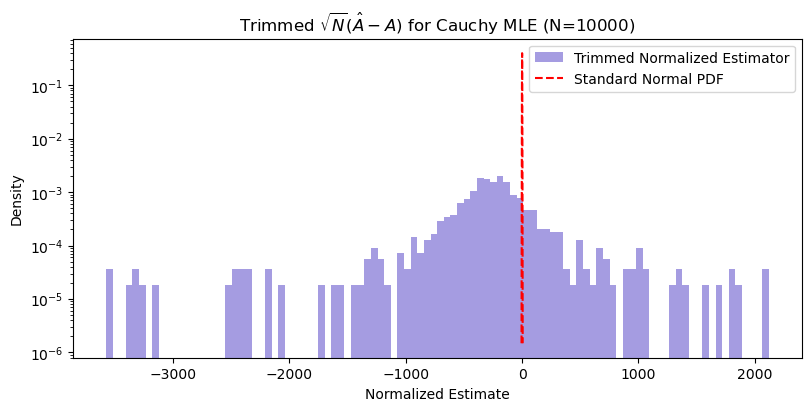

In [109]:
from scipy.stats import norm

def plot_normalized_cauchy(estimates, A=1, gamma=np.sqrt(2)*cg, trim_percentile=2):
    fisher_info = 1 / (2 * gamma ** 2)
    std_dev = np.sqrt(1 / fisher_info)

    for n in sample_sizes:
        ests = np.array(estimates[n])
        Z = (np.sqrt(n) * (ests - A)) / std_dev  # Normalize

        # Trim outliers using percentiles
        lower = np.percentile(Z, trim_percentile)
        upper = np.percentile(Z, 100 - trim_percentile)
        Z_trimmed = Z[(Z >= lower) & (Z <= upper)]

        fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

        # Histogram of trimmed normalized values
        ax.hist(Z_trimmed, bins=100, density=True, alpha=0.6, color='slateblue', label='Trimmed Normalized Estimator')

        # Plot standard normal PDF
        x = np.linspace(-5, 5, 1000)
        ax.plot(x, norm.pdf(x), 'r--', label='Standard Normal PDF')

        ax.set_title(rf'Trimmed $\sqrt{{N}}(\hat{{A}} - A)$ for Cauchy MLE (N={n})')
        ax.set_xlabel('Normalized Estimate')
        ax.set_yscale('log')
        ax.set_ylabel('Density')
        ax.legend()
        plt.show()



plot_normalized_cauchy(estimates_A1, A=A)



In [130]:
import numpy as np
from tqdm import tqdm

# Assuming you already have:
# - realisations(n, a, num_realisations)
# - get_statistics(estimates)
# - iter_over_sample_size(ns, a, num_realisations)
# - mle_estimates and random_generator defined elsewhere
# - cg is defined

sample_sizes = [1, 10, 100, 1000, 10000]
num_realisations = 1000

# Store results
all_stats = {}

# Evaluate for both A = 1 and A = 10
for A in [1, 10]:
    print(f"\n--- MLE Results for Cauchy | A = {A} ---")
    estimates, stats = iter_over_sample_size(sample_sizes, A, num_realisations)
    all_stats[A] = stats  # Save stats for later use or plotting
    for n in sample_sizes:
        mean = stats[n]['cauchy']['mean']
        var = stats[n]['cauchy']['var']
        print(f"N={n:<6} | Mean: {mean:.4f} | Variance: {var:.4f}")



--- MLE Results for Cauchy | A = 1 ---


Sample size: n=10:  20%|██        | 1/5 [00:00<00:01,  3.74it/s]

Done: n=1, num_real=1000


Sample size: n=100:  40%|████      | 2/5 [00:07<00:13,  4.35s/it]

Done: n=10, num_real=1000


Sample size: n=1000:  60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

Done: n=100, num_real=1000


Sample size: n=10000:  80%|████████  | 4/5 [00:08<00:01,  1.73s/it]

Done: n=1000, num_real=1000


Sample size: n=10000: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Done: n=10000, num_real=1000
N=1      | Mean: -5.4546 | Variance: 18158.2981
N=10     | Mean: 6709.8442 | Variance: 58527255081.1054
N=100    | Mean: 1.0060 | Variance: 0.0764
N=1000   | Mean: 0.9993 | Variance: 0.0075
N=10000  | Mean: 1.0010 | Variance: 0.0007

--- MLE Results for Cauchy | A = 10 ---


Sample size: n=10:  20%|██        | 1/5 [00:00<00:00,  5.31it/s]

Done: n=1, num_real=1000


Sample size: n=100:  40%|████      | 2/5 [00:04<00:07,  2.60s/it]

Done: n=10, num_real=1000


Sample size: n=1000:  60%|██████    | 3/5 [00:04<00:03,  1.52s/it]

Done: n=100, num_real=1000


Sample size: n=10000:  80%|████████  | 4/5 [00:05<00:01,  1.06s/it]

Done: n=1000, num_real=1000


Sample size: n=10000: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

Done: n=10000, num_real=1000
N=1      | Mean: 10.0398 | Variance: 1244.7554
N=10     | Mean: -11362.0262 | Variance: 46136682432.1125
N=100    | Mean: 9.9860 | Variance: 0.0728
N=1000   | Mean: 10.0008 | Variance: 0.0069
N=10000  | Mean: 10.0000 | Variance: 0.0006


Sample size: n=10:  20%|██        | 1/5 [00:00<00:01,  3.62it/s]

Done: n=1, num_real=1000


Sample size: n=100:  40%|████      | 2/5 [00:08<00:14,  4.82s/it]

Done: n=10, num_real=1000


Sample size: n=1000:  60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

Done: n=100, num_real=1000


Sample size: n=10000:  80%|████████  | 4/5 [00:09<00:01,  1.84s/it]

Done: n=1000, num_real=1000


Sample size: n=10000: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Done: n=10000, num_real=1000
980


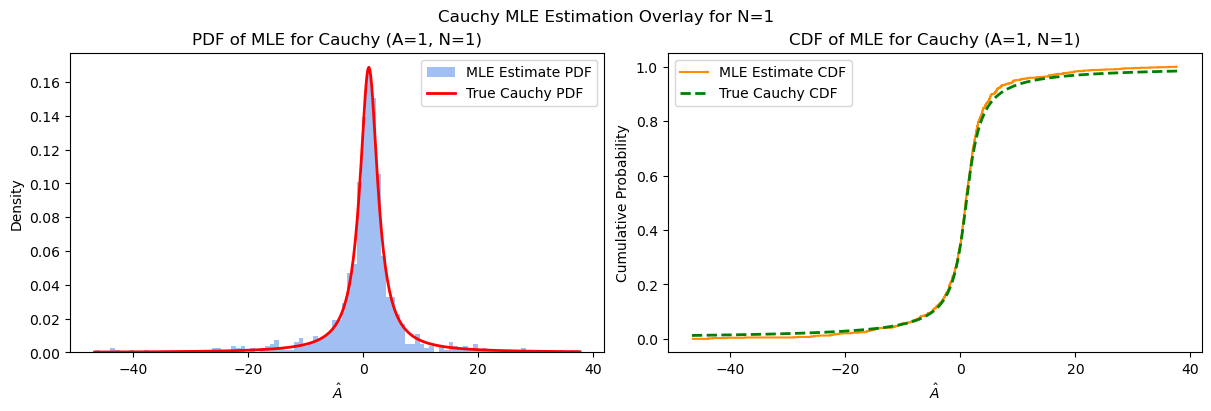

980


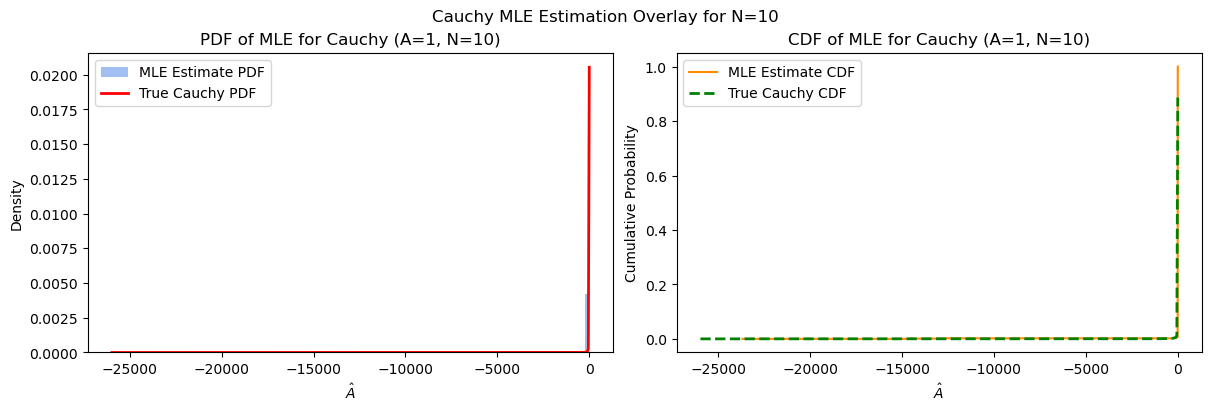

980


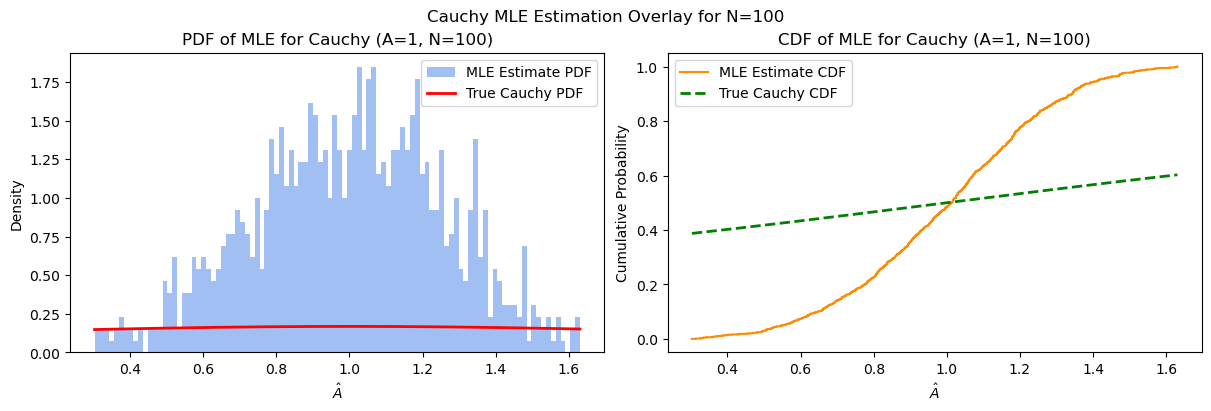

980


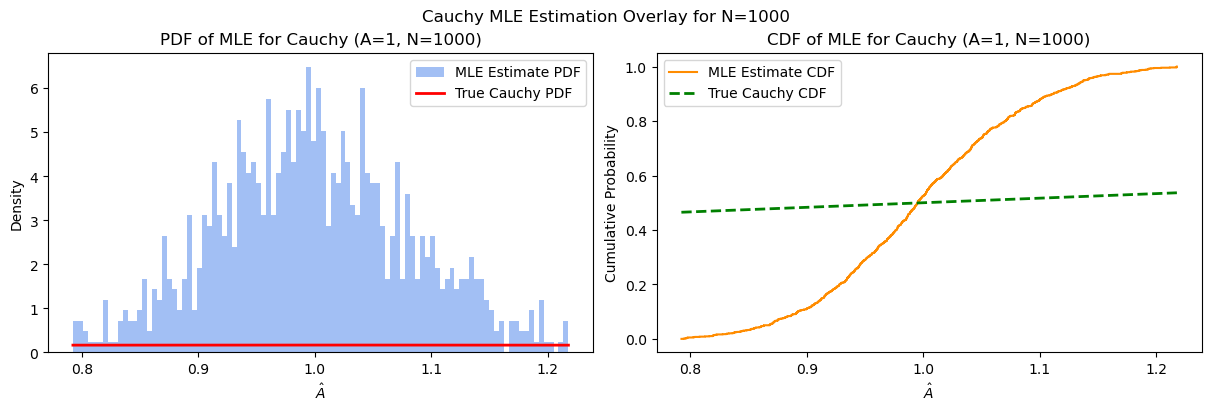

980


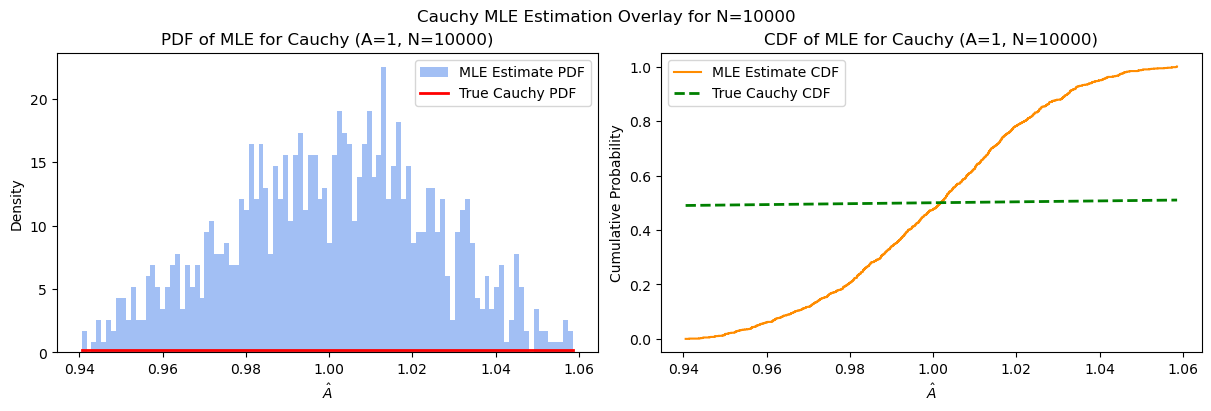

In [ ]:
from scipy.stats import cauchy

def plot_cauchy_pdf_cdf(estimates, A, gamma=np.sqrt(2*cg), trim_percentile=0.01):
    """
    Plot PDF and CDF for MLE estimates of Cauchy with real Cauchy PDF/CDF overlay.
    
    Parameters:
    - estimates: dict of estimates[n][distribution] (only uses 'cauchy')
    - A: true location parameter
    - gamma: scale parameter of Cauchy
    - trim_percentile: fraction to trim from both tails for better visualization
    """
    for n in range(len(estimates)):
        ests = np.array(estimates[n]['cauchy'])

        # Trim outliers for visualization
        lower = np.percentile(ests, 100 * trim_percentile)
        upper = np.percentile(ests, 100 * (1 - trim_percentile))
        ests_trimmed = ests[(ests >= lower) & (ests <= upper)]

        fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")

        # Histogram (PDF)
        bins = 100
        axs[0].hist(ests_trimmed, bins=bins, density=True, alpha=0.6, color='cornflowerblue', label='MLE Estimate PDF')
        x_vals = np.linspace(lower, upper, 500)
        axs[0].plot(x_vals, cauchy.pdf(x_vals, loc=A, scale=gamma), color='red', lw=2, label='True Cauchy PDF')
        axs[0].set_title(f'PDF of MLE for Cauchy (A={A}, N={n})')
        axs[0].set_xlabel(r'$\hat{A}$')
        axs[0].set_ylabel('Density')
        axs[0].legend()

        # Empirical CDF
        sorted_est = np.sort(ests_trimmed)
        print(len(sorted_est))
        cdf = np.linspace(0, 1, len(sorted_est))
        axs[1].step(sorted_est, cdf, where='post', color='darkorange', label='MLE Estimate CDF')
        axs[1].plot(x_vals, cauchy.cdf(x_vals, loc=A, scale=gamma), color='green', lw=2, linestyle='--', label='True Cauchy CDF')
        axs[1].set_title(f'CDF of MLE for Cauchy (A={A}, N={n})')
        axs[1].set_xlabel(r'$\hat{A}$')
        axs[1].set_ylabel('Cumulative Probability')
        axs[1].legend()

        plt.suptitle(f'Cauchy MLE Estimation Overlay for N={n}')
        plt.show()

sample_sizes = [1, 10, 100, 1000, 10000]
num_realisations = 1000
A = 1  # or 10

estimates, stats = iter_over_sample_size(sample_sizes, A, num_realisations)
plot_cauchy_pdf_cdf(estimates, A)


In [132]:
from scipy.stats import norm

def plot_normalized_mle(estimates, A, gamma=np.sqrt(2 * cg), trim_percentile=0.01):
    """
    Plot normalized MLE estimates: sqrt(N) * (A_hat - A) ~ N(0, 1/I(A))
    Overlays theoretical normal PDF and CDF
    """
    fisher_info_inv = 2 * gamma**2  # I(A)^(-1)
    std = np.sqrt(fisher_info_inv)

    for n in estimates:
        A_hat = np.array(estimates[n]["cauchy"])
        normalized = np.sqrt(n) * (A_hat - A)

        # Trim outliers
        lower = np.percentile(normalized, 100 * trim_percentile)
        upper = np.percentile(normalized, 100 * (1 - trim_percentile))
        norm_trimmed = normalized[(normalized >= lower) & (normalized <= upper)]

        fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")

        # PDF
        x = np.linspace(min(norm_trimmed), max(norm_trimmed), 500)
        axs[0].hist(norm_trimmed, bins=100, density=True, alpha=0.6, label='Empirical', color='cornflowerblue')
        axs[0].plot(x, norm.pdf(x, 0, std), 'r-', label='Theoretical Normal PDF')
        axs[0].set_title(rf'PDF of $\sqrt{{N}}(\hat{{A}} - A)$ (N={n})')
        axs[0].set_xlabel(r'$\sqrt{N}(\hat{A} - A)$')
        axs[0].set_ylabel('Density')
        axs[0].legend()

        # CDF
        sorted_norm = np.sort(norm_trimmed)
        cdf_empirical = np.linspace(0, 1, len(sorted_norm))
        axs[1].step(sorted_norm, cdf_empirical, where='post', color='darkorange', label='Empirical CDF')
        axs[1].plot(x, norm.cdf(x, 0, std), 'r-', label='Theoretical Normal CDF')
        axs[1].set_title(rf'CDF of $\sqrt{{N}}(\hat{{A}} - A)$ (N={n})')
        axs[1].set_xlabel(r'$\sqrt{N}(\hat{A} - A)$')
        axs[1].set_ylabel('Cumulative Probability')
        axs[1].legend()

        plt.suptitle(f'Normalized MLE vs Normal Distribution (N={n})')
        plt.show()


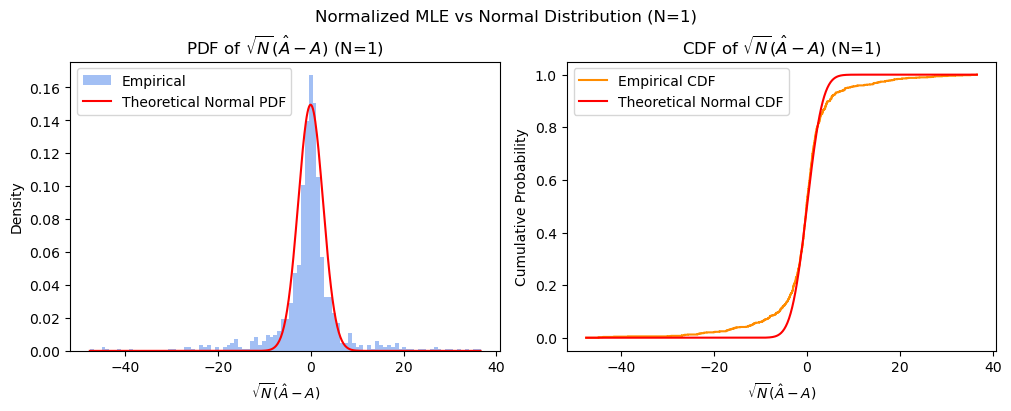

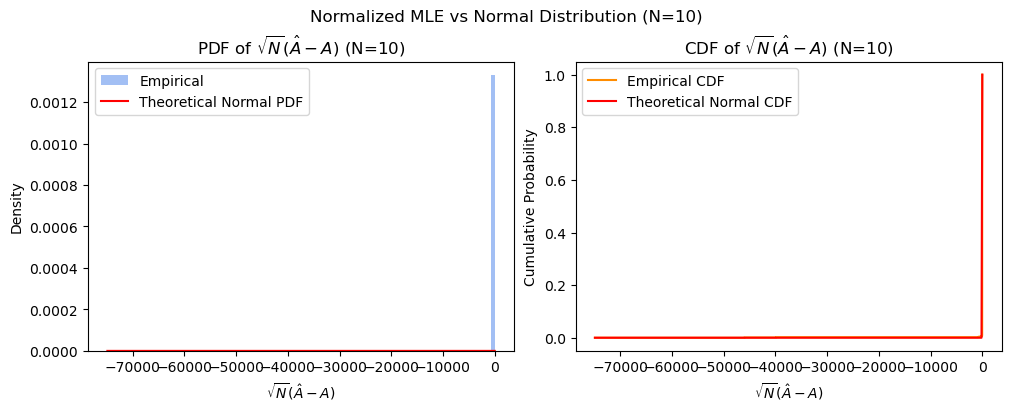

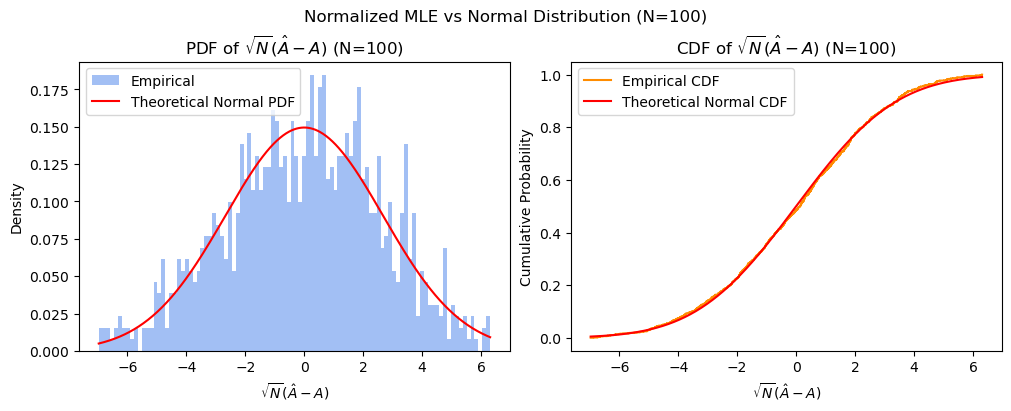

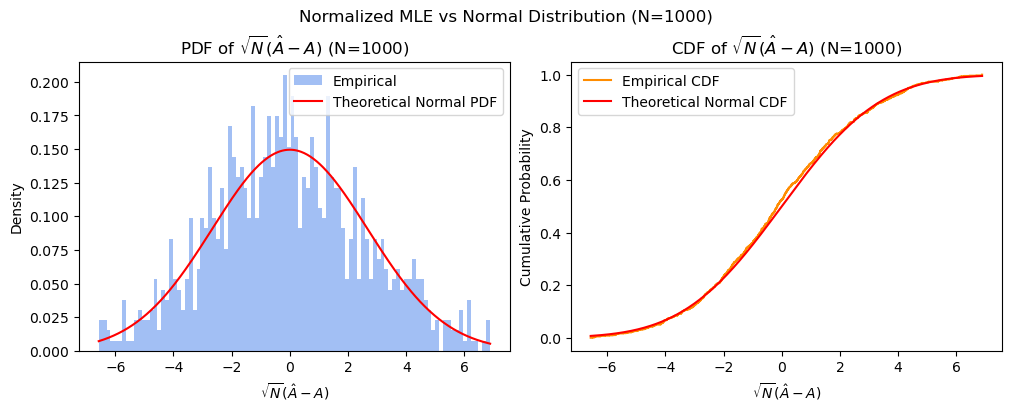

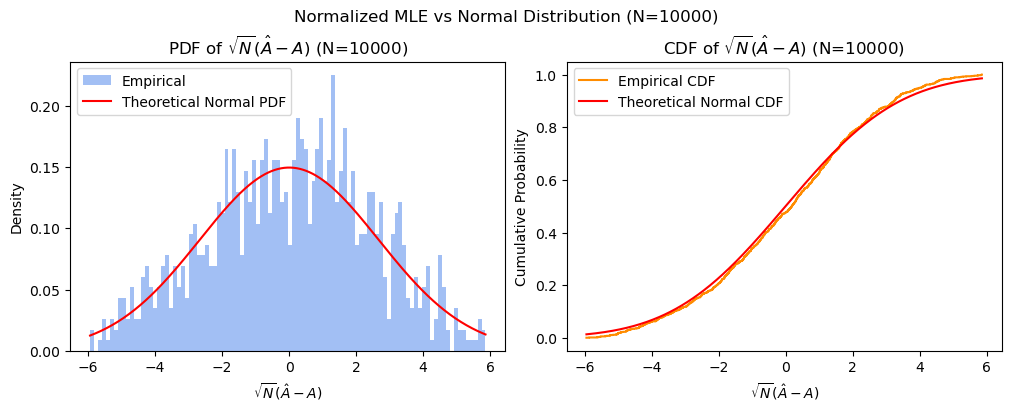

In [133]:
plot_normalized_mle(estimates, A)